In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = "data/pp_check"
seed_data = pd.read_csv(os.path.join(data_folder, 'pp_sample_ipu.csv'))
seed_data = seed_data.drop(columns=["sample_geog"])
seed_data

,serialno,age,sex,relationship,persinc,nolicence,anywork
0,Y12H0000101,50-59,M,Main,$1000-1249 p.w.,Some Licence,Y
1,Y12H0000101,40-49,F,Spouse,$1-199 p.w.,Some Licence,N
2,Y12H0000101,10-19,F,Child,Zero Income,No Licence,N
3,Y12H0000101,0-9,F,Child,Zero Income,No Licence,N
4,Y12H0000102,50-59,F,Parent,$1-199 p.w.,Some Licence,N
...,...,...,...,...,...,...,...
75404,Y20H4001028,60-69,F,Main,$400-599 p.w.,Some Licence,Y
75405,Y20H4001029,70-79,M,Main,$300-399 p.w.,Some Licence,N
75406,Y20H4001029,70-79,F,Spouse,$300-399 p.w.,Some Licence,N
75407,Y20H4001036,70-79,F,Main,$400-599 p.w.,Some Licence,N


In [3]:
# saa_data = pd.read_csv(os.path.join(data_folder, 'SAA_PP_seed_test.csv'))
csp_seed_data = pd.read_csv(os.path.join(data_folder, 'csp_results_allz.csv'))
ipu_data = pd.read_csv(os.path.join(data_folder, 'syn_pp_ipu.csv'))
# csp_bn_data = pd.read_csv(os.path.join(data_folder, 'csp_results_BN_better_constraints.csv'))
# hhsz_bn_data = pd.read_csv(os.path.join(data_folder, 'syn_pp_bn_hhsz_constraint.csv'))
pure_ctgan = pd.read_csv(os.path.join(data_folder, 'pp_synthetic_ctgan.csv'))
csp_from_bn = pd.read_csv(os.path.join(data_folder, 'csp_BN_direct_hhtype.csv'))

In [4]:
pp_persinc_order = [
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]

In [5]:
check = {
    "IPU": ipu_data,
    # "SAA": saa_data,
    # "BN-hhsz": hhsz_bn_data,
    "CSP-Seed": csp_seed_data,
    "CSP-BN": csp_from_bn,
    # "CSP-BN": csp_bn_data,
    "CTGAN": pure_ctgan,
    "VISTA": seed_data
}

In [6]:
label_colors = {
    "IPU": "red", 
    "CSP-Seed": "blue",
    "CSP-BN": "green",
    "CTGAN": "purple",
    "VISTA": "black",
    }

In [7]:
def check_spouse_type(dict_data):
    def check_hh_type(row):
        relationships = row["relationship"]
        sex = row["sex"]
        if "Spouse" not in relationships:
            return "No Spouse"
        n_spouse = relationships.count("Spouse")
        spouse_idx = relationships.index("Spouse")
        main_idx = relationships.index("Main")
        n_child = relationships.count("Child")
        if n_spouse > 1 or sex[spouse_idx]==sex[main_idx]:
            if n_child > 0:
                return "Special Spouse\nwith Child"
            return "Special Spouse\nno Child"
        assert n_spouse == 1
        if n_child > 0:
            return "Typical Spouse\nwith Child"
        return "Typical Spouse\nno Child"
    store = {}
    for name, data in dict_data.items():
        if "serialno" not in data.columns:
            continue # skip some cases
        processed = data.groupby("serialno")[["relationship", "sex"]].agg(list)
        processed["spouse_type"] = processed.apply(check_hh_type, axis=1)
        spouse_type_counts = processed["spouse_type"].value_counts(normalize=True)
        store[name] = spouse_type_counts
    return pd.DataFrame(store)

spouse_check = check_spouse_type(check)

<Axes: ylabel='Proportion'>

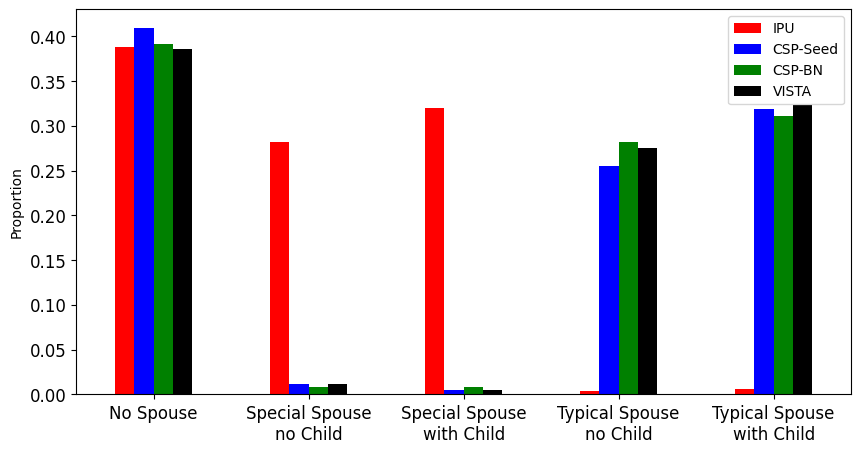

In [8]:
spouse_check.plot(kind="bar", figsize=(10, 5), fontsize=12, rot=0, xlabel="", ylabel="Proportion", legend=True, color=[label_colors.get(col, 'grey') for col in spouse_check.columns])

In [9]:
len(seed_data[seed_data["relationship"].isin(["Main", "Spouse", "Child"])]) / len(seed_data) * 100

90.63109177949582

<Axes: title={'center': 'Relationship Frequency Comparison'}, xlabel='relationship'>

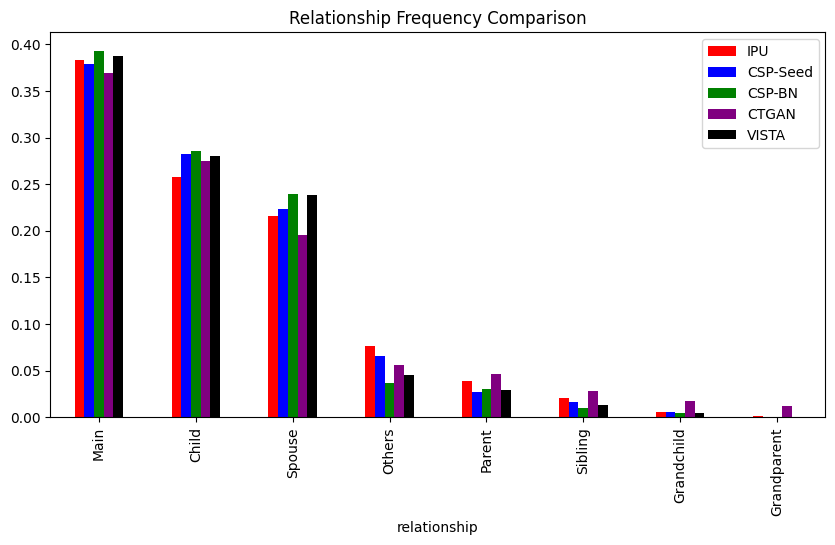

In [10]:
# compare the frequency of each relationships
def compare_freq_rela(check_data):
    hold = {}
    for name, data in check_data.items():
        processed = data["relationship"].value_counts(normalize=True)
        hold[name] = processed
    hold = pd.DataFrame(hold)
    return hold

a = compare_freq_rela(check)
a.plot(kind="bar", figsize=(10, 5), title="Relationship Frequency Comparison", color=[label_colors.get(col, 'grey') for col in a.columns])

In [11]:
def compare_rela(check_data, rela, attr):
    process_sub = {name: df[df["relationship"]==rela] for name, df in check_data.items()}
    if attr == "persinc":
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(pp_persinc_order) for name, df in process_sub.items()}
    elif attr == "age":
        expected_order = list(sorted(seed_data[attr].unique()))
        expected_order.remove("100+")
        expected_order.append("100+")
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(expected_order) for name, df in process_sub.items()}
    else:
        process_sub = {name: df[attr].value_counts(normalize=True).sort_index() for name, df in process_sub.items()}

    df_plot = pd.DataFrame(process_sub)
    ax = df_plot.plot(kind="line", marker='o', figsize=(12, 6), title=f"Comparison of {rela} {attr} distribution", alpha=0.5, color=[label_colors.get(col, 'grey') for col in df_plot.columns], fontsize=12)
    ax.set_xticks(ticks=range(len(df_plot.index)), labels=df_plot.index, rotation=45)
    

In [12]:
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt

def compare_jsd_to_vista(check_data, relationships, attr):
    jsd_results = {}

    for rela in relationships:
        # Extract the subset for the given relationship from VISTA
        vista_df = check_data["VISTA"]
        vista_sub = vista_df[vista_df["relationship"] == rela]

        # Compute VISTA distribution
        if attr == "persinc":
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(pp_persinc_order, fill_value=0)
        elif attr == "age":
            expected_order = list(sorted(seed_data[attr].unique()))
            expected_order.remove("100+")
            expected_order.append("100+")
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(expected_order, fill_value=0)
        else:
            all_keys = sorted(set().union(*(df[df["relationship"] == rela][attr].unique() for df in check_data.values())))
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(all_keys, fill_value=0)

        for name, df in check_data.items():
            if name == "VISTA":
                continue  # Skip VISTA itself
            df_sub = df[df["relationship"] == rela]
            if attr == "persinc":
                dist = df_sub[attr].value_counts(normalize=True).reindex(pp_persinc_order, fill_value=0)
            elif attr == "age":
                dist = df_sub[attr].value_counts(normalize=True).reindex(expected_order, fill_value=0)
            else:
                dist = df_sub[attr].value_counts(normalize=True).reindex(vista_dist.index, fill_value=0)

            jsd = jensenshannon(vista_dist, dist)
            jsd_results[(rela, name)] = jsd

    # Create DataFrame for plotting
    result_df = pd.Series(jsd_results).unstack().sort_index()
    result_df.plot(kind='bar', figsize=(10, 6), title=f"Jensen-Shannon Distance to VISTA for '{attr}' by Relationship", color=[label_colors.get(col, 'grey') for col in result_df.columns])
    plt.ylabel("Jensen-Shannon Distance")
    plt.xlabel("Relationship")
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    result_df.loc["mean"] = result_df.mean(axis=0)
    return result_df


In [13]:
# compare_jsd_to_vista(check, list(seed_data["relationship"].unique()), "age")

In [14]:
# compare_jsd_to_vista(check, list(seed_data["relationship"].unique()), "persinc")

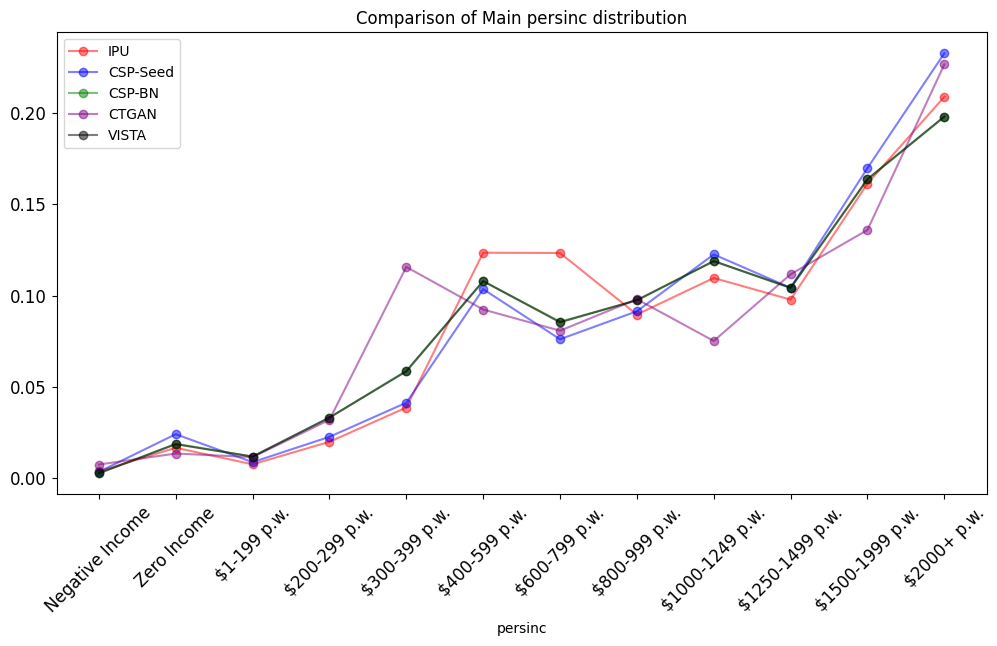

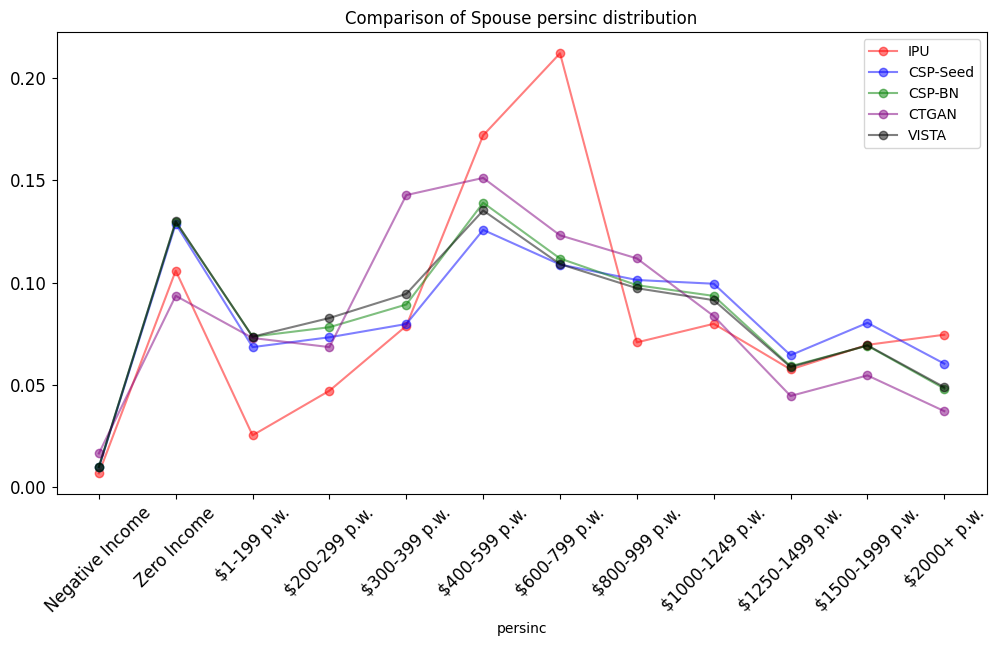

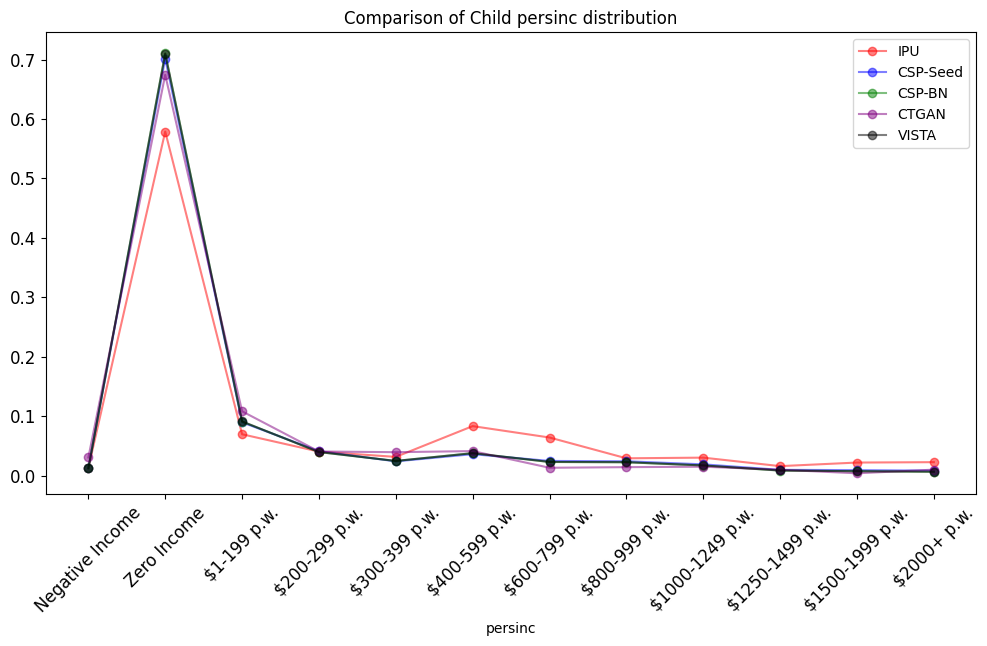

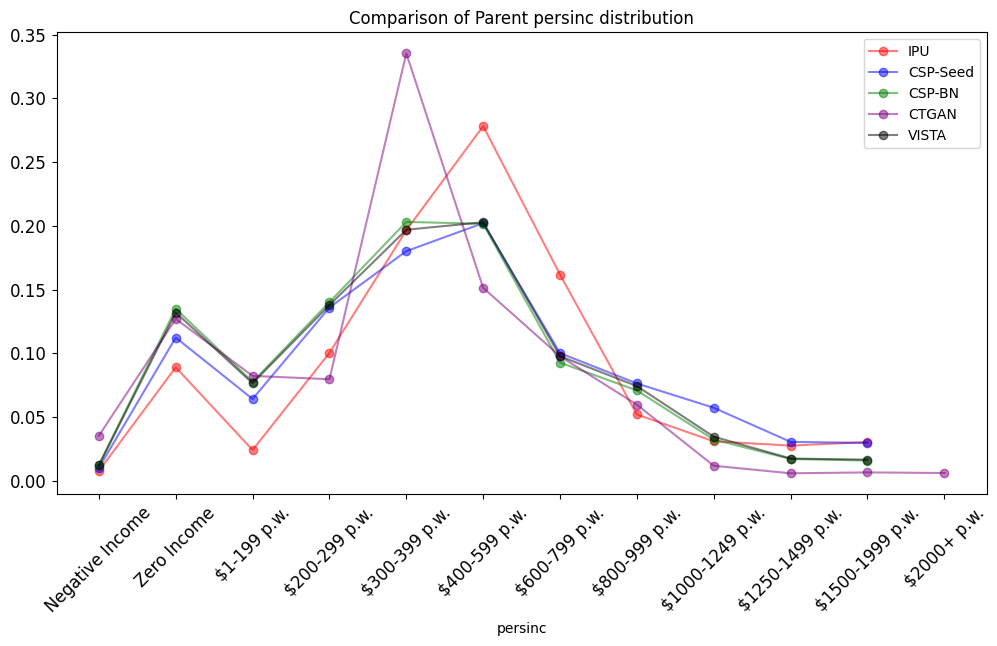

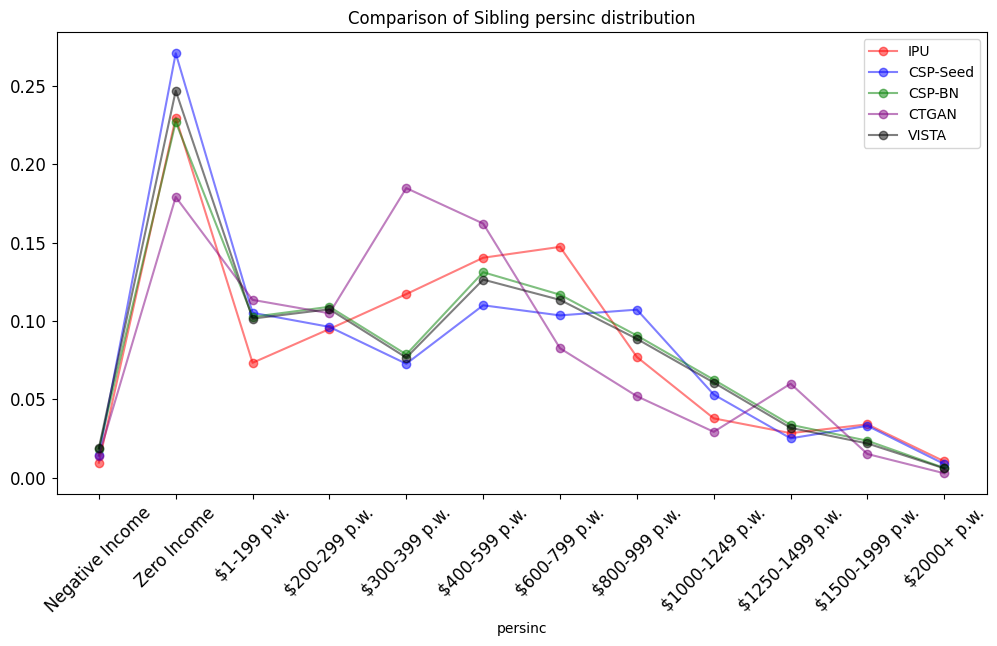

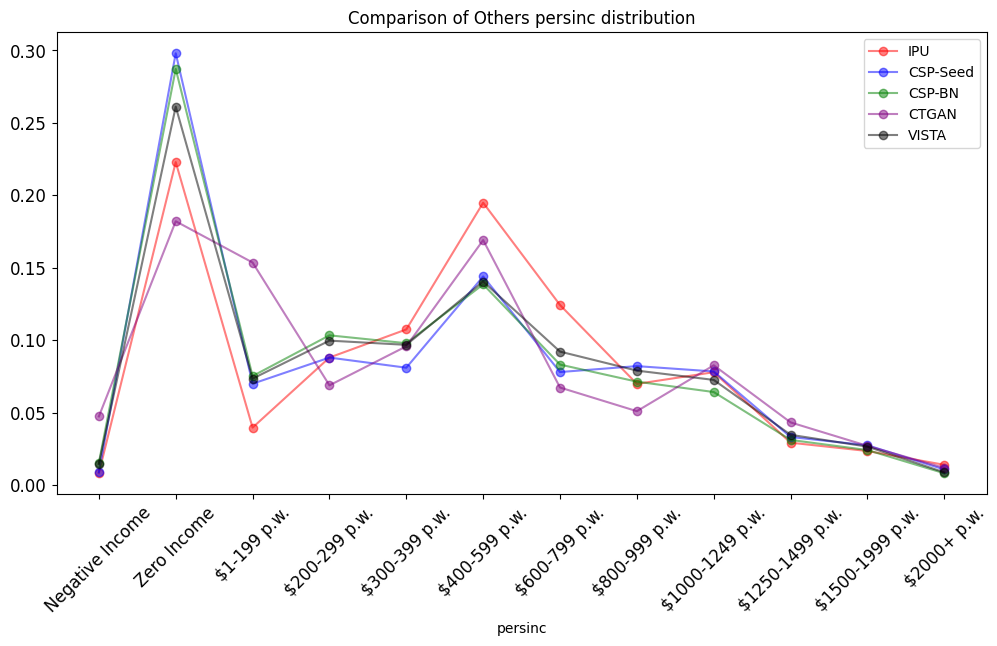

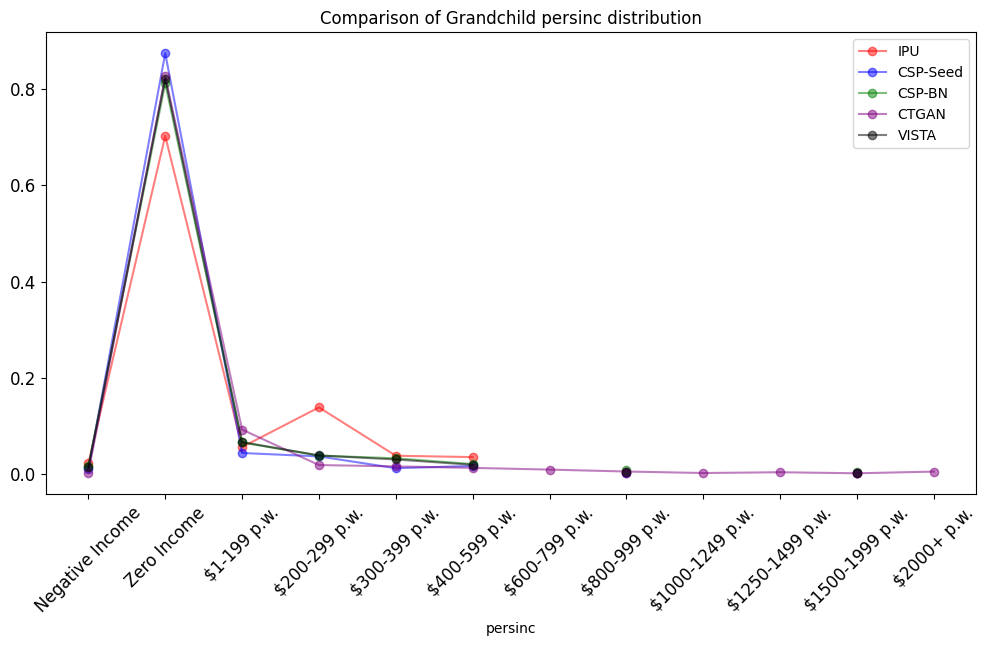

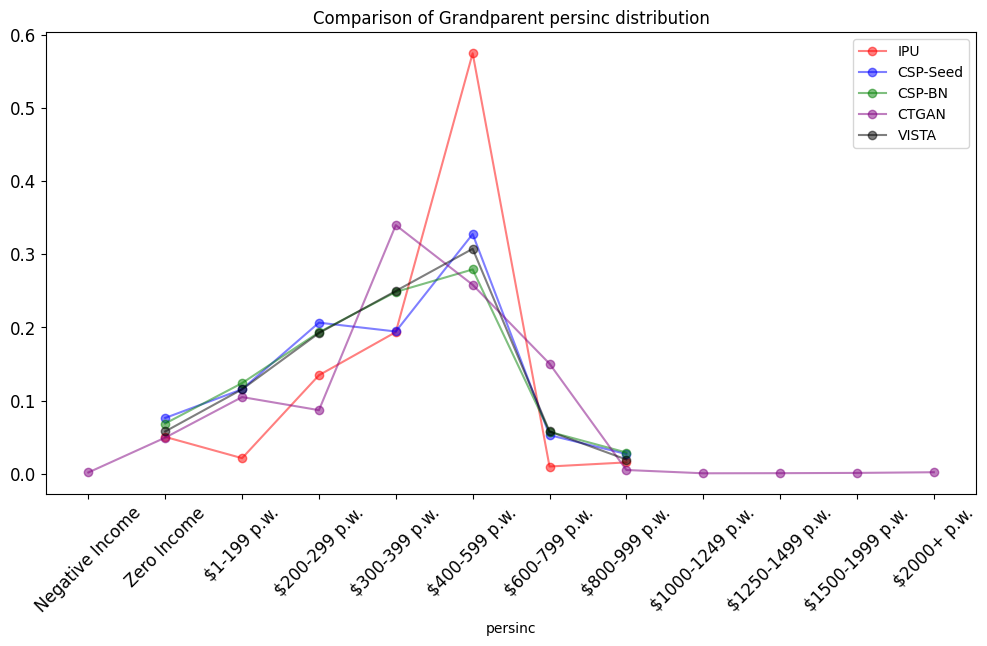

In [15]:
for rela in seed_data["relationship"].unique():
    compare_rela(check, rela, "persinc")

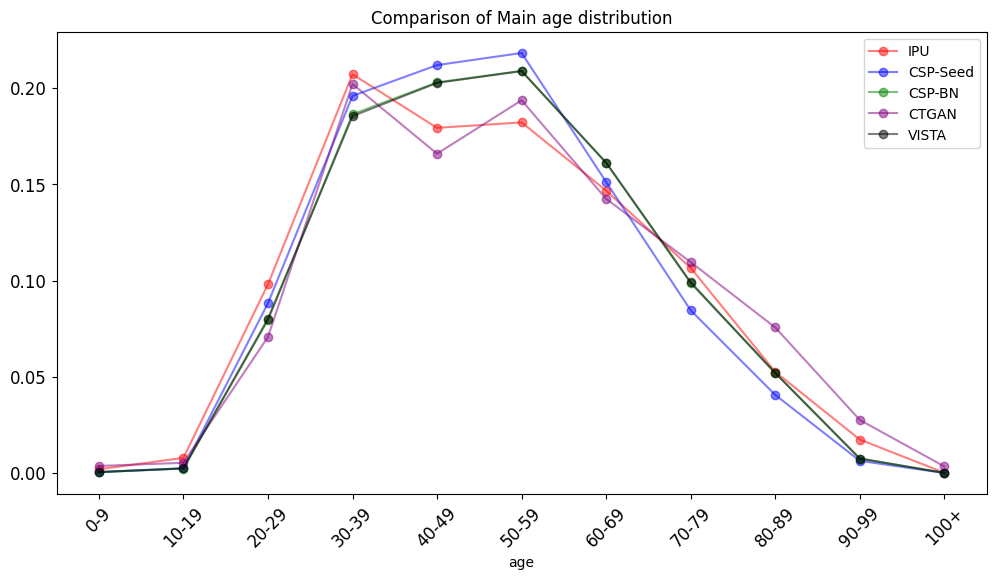

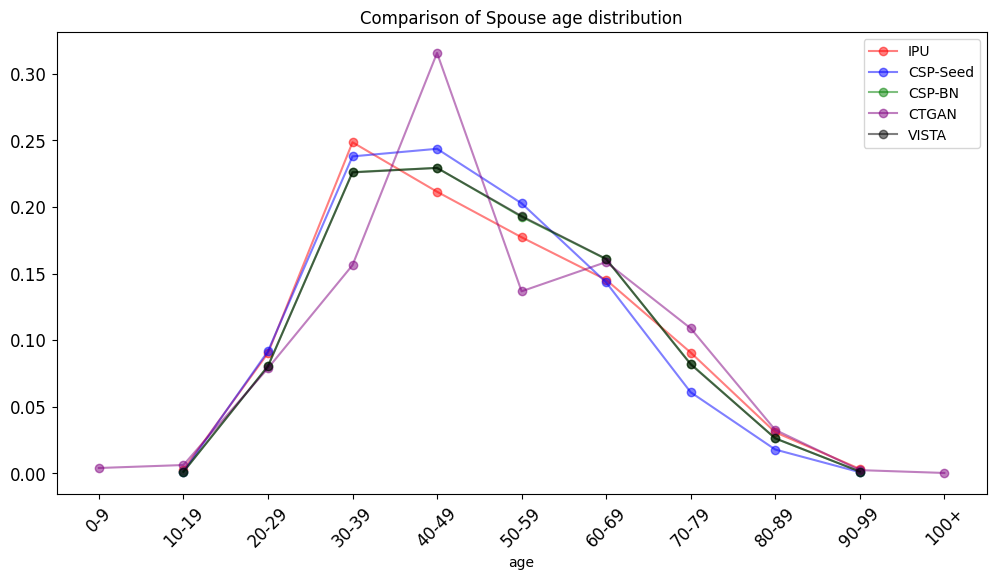

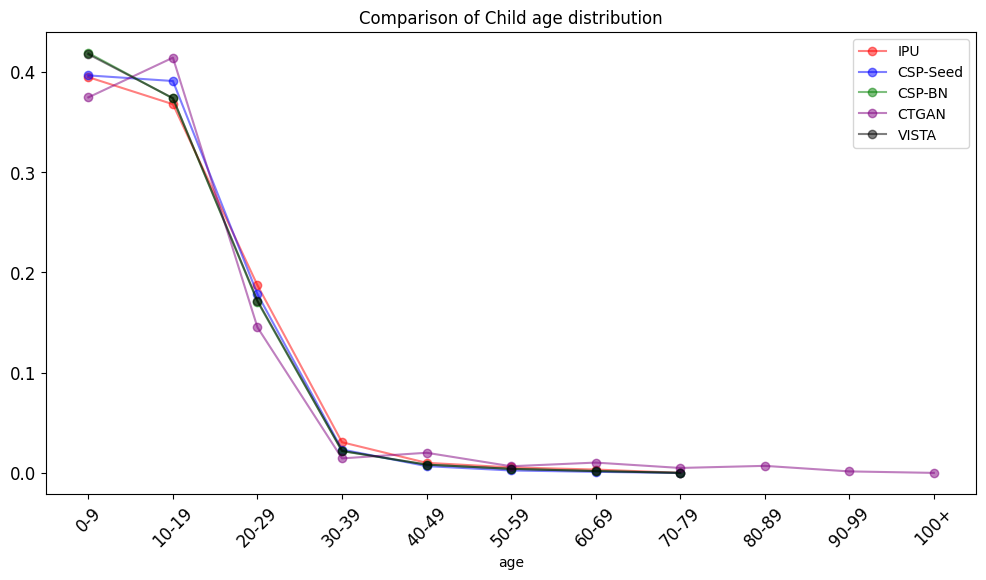

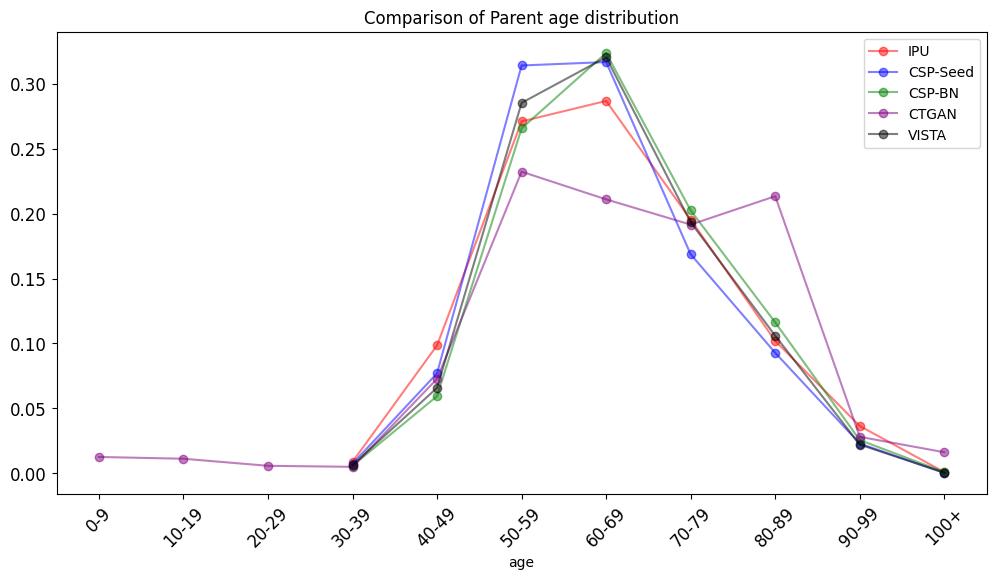

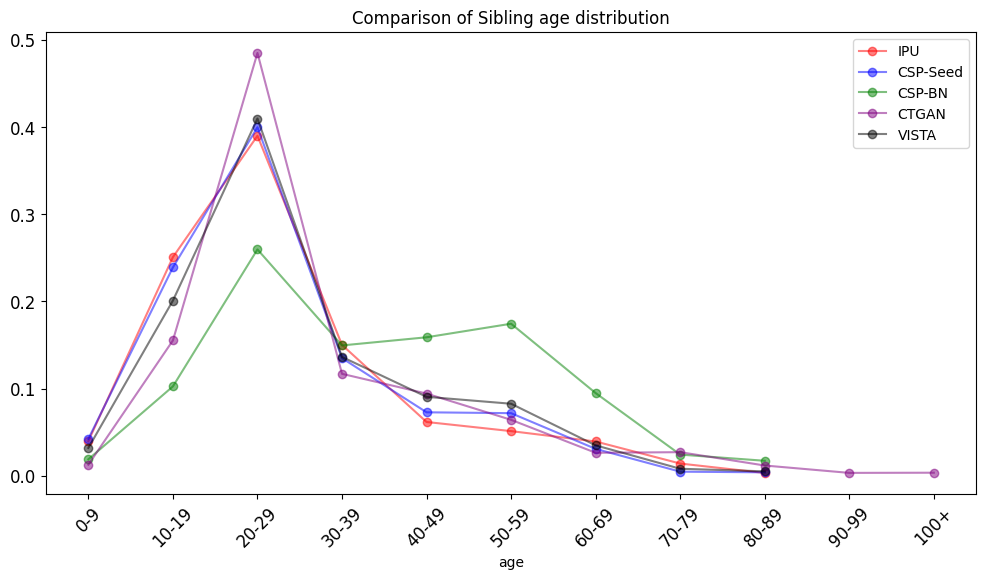

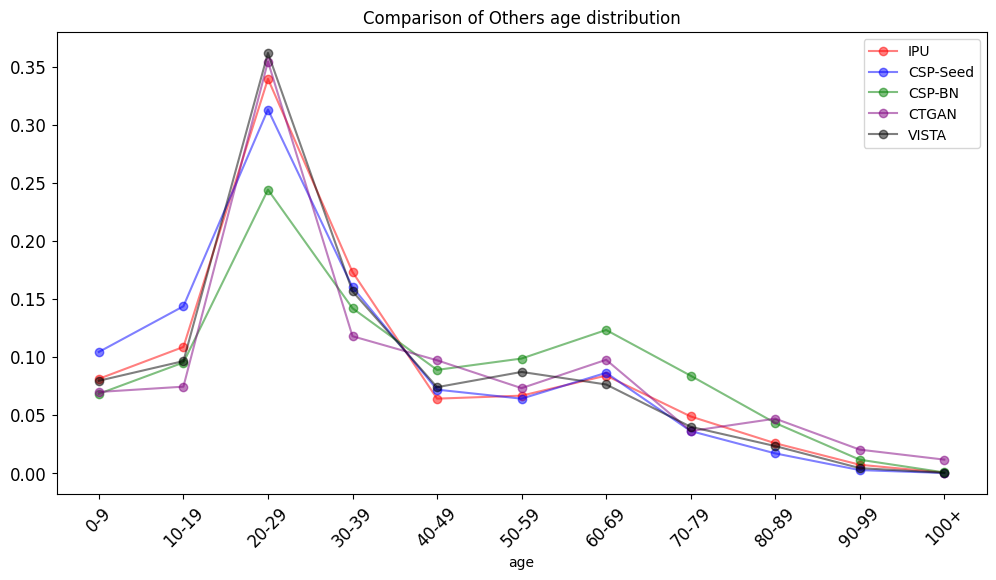

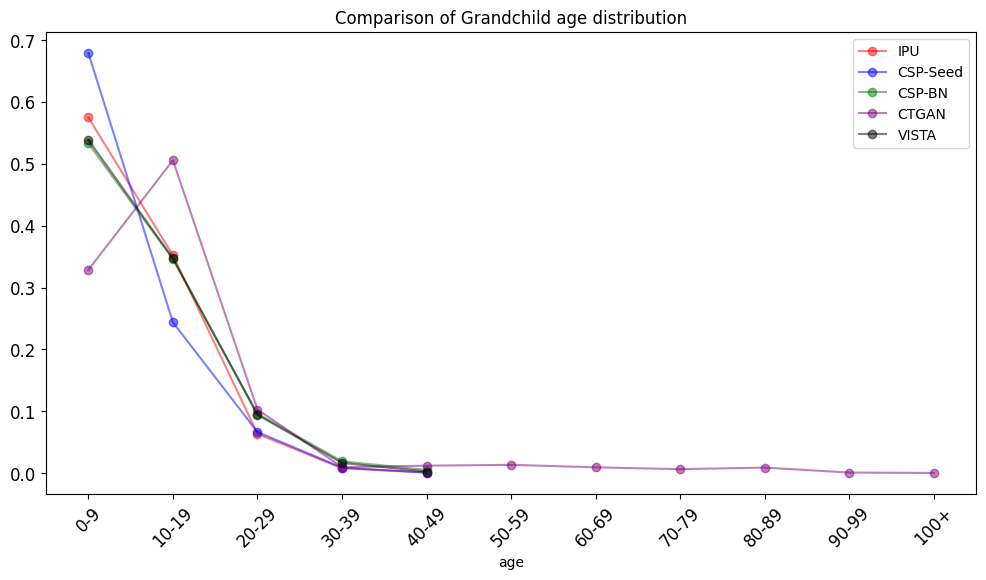

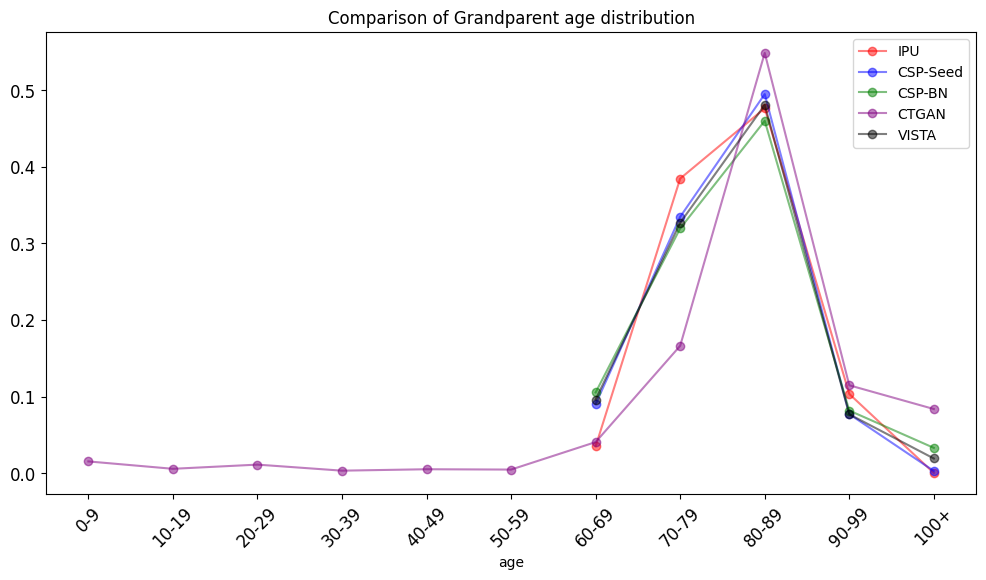

In [16]:
for rela in seed_data["relationship"].unique():
    compare_rela(check, rela, "age")
    plt.show()

In [17]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

def compute_jsd(p, q):
    """Safe computation of Jensen-Shannon Distance"""
    return jensenshannon(p, q, base=2)

def get_jsd_table(dict_dfs, hh_types, atts):
    """
    Compute Jensen-Shannon Distance table for multiple household types and attributes.

    Parameters:
    - dict_dfs: dict of DataFrames (must include 'VISTA' as ground truth)
    - hh_types: list of household types to include
    - atts: list of attribute names to compare

    Returns:
    - MultiIndex DataFrame: (hh_type, attribute) as rows, dataset names as columns
    """
    assert "VISTA" in dict_dfs, "'VISTA' must be present as the ground truth"

    data = []

    for hh_type in hh_types:
        for att in atts:
            vista_df = dict_dfs["VISTA"]
            vista_sub = vista_df[vista_df["relationship"] == hh_type]
            vista_counts = vista_sub[att].value_counts(normalize=True)

            jsd_scores = {}
            for name, df in dict_dfs.items():
                if name == "VISTA":
                    continue
                sub_df = df[df["relationship"] == hh_type]
                dist_counts = sub_df[att].value_counts(normalize=True)

                all_cats = set(vista_counts.index).union(dist_counts.index)
                vista_aligned = vista_counts.reindex(all_cats, fill_value=0).values
                dist_aligned = dist_counts.reindex(all_cats, fill_value=0).values

                jsd = compute_jsd(vista_aligned, dist_aligned)
                jsd_scores[name] = jsd

            # Append to results list as a row
            data.append(((hh_type, att), jsd_scores))

    # Convert to DataFrame
    index = pd.MultiIndex.from_tuples([key for key, _ in data], names=["Relationship", "Attribute"])
    result_df = pd.DataFrame([vals for _, vals in data], index=index)

    return result_df


In [18]:
results = get_jsd_table(check, seed_data["relationship"].unique(),[x for x in seed_data.columns if x not in ["relationship", "serialno"]])

In [19]:
results.mean()

IPU         0.063113
CSP-Seed    0.036063
CSP-BN      0.026012
CTGAN       0.109584
dtype: float64

In [20]:
mean_jsd_per_hhtype = results.groupby(level="Relationship").mean()

<Axes: title={'center': 'Mean JSD per Household Type'}, xlabel='Relationship'>

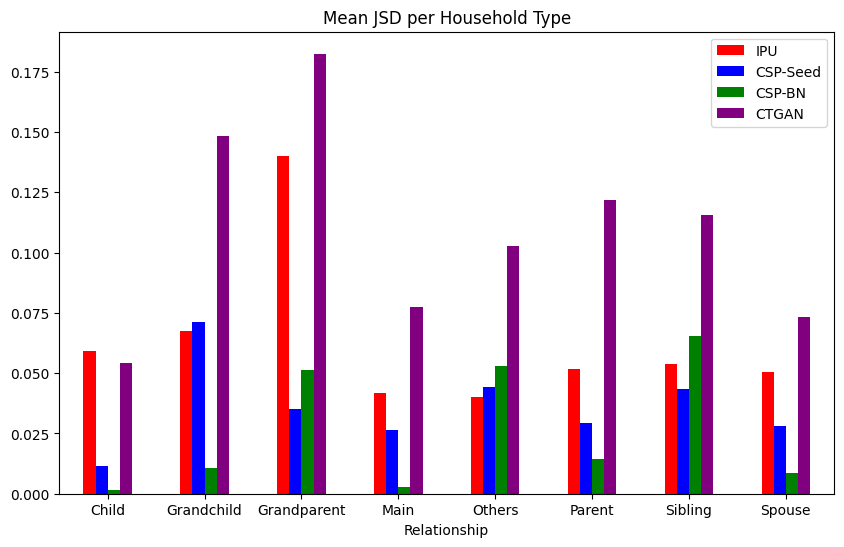

In [ ]:
mean_jsd_per_hhtype.plot(kind="bar", figsize=(10, 6), ylabel="JSD", rot=0, color=[label_colors.get(col, 'grey') for col in mean_jsd_per_hhtype.columns])